In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import time, math
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!python --version

Python 3.7.12


In [7]:
ratings_path = "/content/gdrive/MyDrive/ml-1m/ratings.dat"
movie_path = "/content/gdrive/MyDrive/ml-1m/movies.dat"

names = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(ratings_path, sep='::', names=names)


movies = pd.read_csv(movie_path, sep='::', header=None, usecols=[1])
movies.columns = ['title']

ratings.head()
# movies.iloc[[2,5]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Text(0.5, 1.0, 'Distribution of ratings')

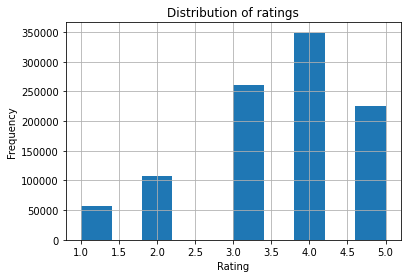

In [8]:
from sklearn.preprocessing import scale

ratings['rating'].hist(grid=True)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of ratings')


In [9]:
X = ratings[['user_id', 'movie_id']].values
y = ratings['rating'].values
print(X)
print(y)

[[   1 1193]
 [   1  661]
 [   1  914]
 ...
 [6040  562]
 [6040 1096]
 [6040 1097]]
[5 3 3 ... 5 4 4]


In [10]:
def create_rating_matrix(X, y, dim):
  r = X[:,0]
  c = X[:,1]
  matrix = csr_matrix((y, (r,c)), shape=(dim[0] + 1, dim[0] + 1))
  M = matrix.todense()
  M = M[1:,1:]
  M = np.asarray(M)
  return M

dim = (np.unique(np.array(X[:,0])).size, np.unique(np.array(X[:,1])).size)
initial_rating_matrix = create_rating_matrix(X, y, dim)
print(initial_rating_matrix)



[[5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]]


In [11]:
users_len = len(ratings['user_id'].unique())
movies_len = len(ratings['movie_id'].unique())
def train(initial_rating_matrix, users, movies, X, y, n_components, alpha_W, alpha_H, l1_ratio, max_iter):
  M = create_rating_matrix(X, y, (users, movies))
  model = NMF(n_components=n_components, init='random', random_state=0, alpha_W = alpha_W, alpha_H=alpha_H, l1_ratio = l1_ratio, max_iter = max_iter)
  return model.fit(M)


def test(model, X_test):
  W = model.transform(X_test)
  H = model.components_.T
  P = H.dot(W.T).T
  P[P > 5] = 5.                   
  P[P < 1] = 1.
  return P, H

# initial_rating_matrix = create_rating_matrix(X, y, (users, movies))
# predicted_rating_matrix, _, _ = train(initial_rating_matrix, users, movies, X, y, 20, 0.01, 0, 15)

# print(predicted_rating_matrix[:10])

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

def split_dataset(X, y, dim):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  M_train = create_rating_matrix(X_train, y_train, dim)
  M_test = create_rating_matrix(X_test, y_test, dim)
  return M_train, M_test, X_train, y_train, X_test, y_test


def calculate_rmse(true_values, predictions):
  predictions = predictions[true_values.nonzero()].flatten() 
  true_values = true_values[true_values.nonzero()].flatten()
  return np.sqrt(mean_squared_error(predictions, true_values))

# print(calculate_rmse(initial_rating_matrix, predicted_rating_matrix))

dim = (np.unique(np.array(X[:,0])).size, np.unique(np.array(X[:,1])).size)
M_train, M_test, X_train, y_train, X_test, y_test = split_dataset(X, y, dim)


M_train_cv, M_test_cv, X_train_cv, y_train_cv, X_test_cv, y_test_cv = split_dataset(X_train, y_train, dim)

def find_best_parameters_with_grid_search():
  grid_search = pd.DataFrame([[0, 0, 0, 0, 0, 0]])
  grid_search.columns = ['n_components', 'alpha_W', 'alpha_H', 'l1_ratio', 'max_iter'] + ['rmse']
  components = [5,20, 40]
  alpha_W = [0.001, 0.1,0.3]
  alpha_H = [0.001, 0.1,0.3]
  l1_ratio = [0]
  iterations = [5, 20, 40]
  dim = (np.unique(np.array(X[:,0])).size, np.unique(np.array(X[:,1])).size)
  i = 0
  for c in components:
    for aw in alpha_W:
      for ah in alpha_H:
        for l in l1_ratio:
          for it in iterations:
            err = 0
            model = train(M_train_cv, dim[0], dim[1], X_train_cv, y_train_cv, c, aw, ah, l, it)
            P_test, H_test = test(model, M_test_cv)

            err = calculate_rmse(P_test, M_test_cv)
            # print(err)

            grid_search.loc[i] = [c, aw, ah, l, it, err]
            i += 1
  # print(i)
  return grid_search

grid_search = find_best_parameters_with_grid_search()
print(grid_search.sort_values('rmse'))


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 5 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 5 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 20 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 40 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 5 reached. Increase it to improve convergence.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-pac

KeyboardInterrupt: ignored

In [15]:
import pickle as cPickle

best_params = [40, 0.01, 0.01, 0, 40]

def final_evaluation():
  model = train(M_train, dim[0], dim[1], X_train, y_train, best_params[0], best_params[1], best_params[2], best_params[3], best_params[4])
  P_test, H_test = test(model, M_test)
  err = calculate_rmse(P_test, M_test)
  return err

print("rmse value is: ", final_evaluation())



# Final training on the hole dataset
dim = (np.unique(np.array(X[:,0])).size, np.unique(np.array(X[:,1])).size)
M = create_rating_matrix(X, y, dim)
model = NMF(n_components=40, init='random', random_state=0, alpha_W = 0.01, alpha_H=0.01, l1_ratio = 0, max_iter = 40, regularization=None)
W = model.fit_transform(M)
H = model.components_.T
P = H.dot(W.T).T            
P[P > 5] = 5.                   
P[P < 1] = 1.

def save_model():
  with open('nmf_model.cpickle', 'wb') as f:
      cPickle.dump(model, f)

save_model()

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 40 reached. Increase it to improve convergence.
  ConvergenceWarning,


rmse value is:  1.0186000054302713


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1435: FutureWarning: `regularization` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 40 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [ ]:
def load_model_and_get_predictions():
  loaded_model = cPickle.load(open("nmf_model.cpickle", 'rb'))
  W = loaded_model.transform(create_rating_matrix(X, y, (users, movies)))
  # W = model.transform(X_test)
  H = loaded_model.components_.T
  P = H.dot(W.T).T
  P[P > 5] = 5.                   
  P[P < 1] = 1.
  # print(P)
  return P
load_model_and_get_predictions()

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1435: FutureWarning: `regularization` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,


array([[3.15977215, 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.31832295, 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.40984227, 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.27463521, 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.52771235, 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

In [ ]:
# initial_rating_matrix = create_rating_matrix(X, y, (users, movies))
predicted_rating_matrix = load_model_and_get_predictions()
print(predicted_rating_matrix)

def make_recommendation_for_an_existing_user(initial_rating_matrix, predicted_rating_matrix, movies, user_idx, k=5):
    user_ratings = pd.DataFrame(initial_rating_matrix).iloc[user_idx, :]              
    user_prediction = pd.DataFrame(predicted_rating_matrix).iloc[user_idx,:]
    preferred_movies = np.flip(np.argsort(np.array(user_ratings))[-k:])
    recommended_movies = np.flip(np.argsort(np.array(user_prediction))[-k:])

    print("Preferred movies: ")
    print(movies.iloc[preferred_movies])
    print()
    print("Recommended movies: ") 
    print(movies.iloc[recommended_movies])

make_recommendation_for_an_existing_user(initial_rating_matrix, predicted_rating_matrix, movies, user_idx=10, k=5)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1435: FutureWarning: `regularization` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,


[[3.15977215 1.         1.         ... 1.         1.         1.        ]
 [1.31832295 1.         1.         ... 1.         1.         1.        ]
 [1.40984227 1.         1.         ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.27463521 1.         1.         ... 1.         1.         1.        ]
 [1.52771235 1.         1.         ... 1.         1.         1.        ]]
Preferred movies: 
                                          title
2579                        Frankenstein (1931)
1783                      Love Walked In (1998)
592                            Pinocchio (1940)
2108                         Family Plot (1976)
763   Touki Bouki (Journey of the Hyena) (1973)

Recommended movies: 
                                    title
2857                     Hairspray (1988)
2761  Cabaret Balkan (Bure Baruta) (1998)
592                      Pinocchio (1940)
317                         Suture (1993)
295              